Dividend forecasting.


The mathematical formula for long-term stock forecasting was identified in our previous research paper. Based on the definition of annualized return, the formula dissects the stock return into three components: Dividends, Sales Per Share, and Price-to-Sales (P/Sales). The focus of this paper is a fundamental statistical analysis aiming to predict future stock returns if you can accurately forecast these three components. Our previous research focused on predicting the future P/S ratio, and another on predicting the future sales growth.

The imports


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display_jpeg

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import linregress
import statsmodels.api as sm

# SimFin imports.
import simfin as sf
from simfin.names import *

In this code, multiple Python libraries are imported for data analysis and visualization. The first line ("%matplotlib inline") is a magic command that allows the plotting of graphs and visualizations within the Jupyter Notebook itself. Under the alias "plt", the second line imports the "matplotlib.pyplot" module that provides a collection of functions for creating graphs. From the "IPython.display" module, the "display_jpeg" function is imported. Using this function, you can display JPEG images in Jupyter Notebooks. The next block of code imports several libraries to analyze and model data. The libraries include "pandas" (for data manipulation and analysis), "numpy" (for numerical computation), "seaborn" (for data visualization), "scipy.stats.linregress" (for linear regression analysis), and "statsmodels.api" (for statistical models).  The final two lines import the necessary modules from the "simfin" A library that provides financial data enables easy access and retrieval of financial data for a variety of companies. In general, this code sets up a data analysis, visualization, and financial data retrieval environment by importing the necessary libraries and modules.

In [2]:
# Version of the SimFin Python API.
sf.__version__

'0.6.0'

It checks the version of the SimFin Python API. SimFin Python API is a library for accessing financial data from SimFin's database. By running this line of code, we can find out what version we are currently using. We can then see if we are using the most updated version or if there are newer versions available with additional features or bug fixes.


Config. Install and configure the Python packages.


In [3]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

This code sets the SimFin data directory to a specific location. The data directory is a folder where SimFin library will store and access financial data. By setting the data directory, the code ensures that the SimFin library knows where to find the data that it needs to perform financial analysis or calculations. The specified location for the data directory is "~/simfin_data/". The tilde symbol (~) typically represents the user's home directory in a Unix-like operating system. Therefore, this The SimFin data directory is set to a folder named "simfin_data" within the user's home directory.

In [4]:
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

This code is responsible for loading the API key for SimFin data. SimFin is a financial database that provides historical financial statements and company data. The API key is a unique code that grants access to SimFin's data. By calling the `load_api_key()` function, the code tries to load an API key from a specific file path, which is "~/simfin_api_key.txt" in this case. If the API key file is found, the key is loaded and can be used to access SimFin's premium data. However, if the key file is If it is absent or empty, SimFin's free data will be used instead, which has some limitations compared to premium data.

In [5]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

By default, Seaborn sets its plotting style to a white grid, which means that plots have a white background with horizontal and vertical grid lines. This line of code sets the plotting style of Seaborn, a Python data visualization library. It is possible to change how Seaborn plots appear and format plots by changing the plotting style.


Data-Hub. SimFin is used to load and process financial data:


In [6]:
hub_args = \
{
    # We are interested in the US stock-market.
    'market': 'us',

    # Use last-known values to fill in missing values.
    'fill_method': 'ffill',

    # Refresh the fundamental datasets (Income Statements etc.)
    # every 30 days.
    'refresh_days': 30,

    # Refresh the dataset with shareprices every 10 days.
    'refresh_days_shareprices': 10
}

This code is defining a dictionary called `hub_args` with four key-value pairs.   The first key is `'market'` and its value is `'us'`. This tells us that the code is specifically interested in the US stock market.  The second key is `'fill_method'` and its value is `'ffill'`. This suggests that when there are missing values in the data, the code will use the last-known values to fill in those missing values.  The third key is `'refresh_days'` and its value is `30`. This indicates that the There is a fourth key, called 'refresh_days_shareprices', whose value is 10. This means that the dataset containing share prices will be refreshed or updated every 10 days.

As a result, we can create a `StockHub` object to handle all the data and signal processing:


In [7]:
%%time
hub = sf.StockHub(**hub_args)

CPU times: user 11 µs, sys: 2 µs, total: 13 µs
Wall time: 15.7 µs


As part of this code snippet, the following code is executed for a specified time. Using the arguments passed to the "hub_args" variable, the second line of code creates a variable called "hub" and assigns it the value returned by calling the "StockHub" class from the "sf" module.


Signals. By using the stock-hub, we can calculate the signals that we will be using in our analysis, such as sales growth and net profit margin.


In [8]:
%%time
# Calculate Growth Signals.
# We set variant='quarterly' to get 4 data-points per year,
# but the data used to calculate the growth signals is TTM.
df_growth_signals = hub.growth_signals(variant='quarterly')

# Calculate Financial Signals. Also 4 data-points per year.
df_fin_signals = hub.fin_signals(variant='quarterly')

# Calculate the 1-year change in the Financial Signals.
df_fin_signals_chg = hub.fin_signals(variant='quarterly',
                                     func=sf.rel_change_ttm_1y)

# Rename columns for the 1-year changes.
def rename_chg(s):
    return s + ' (1Y Change)'
df_fin_signals_chg.rename(mapper=rename_chg, axis='columns', inplace=True)

# Combine all the signals we have calculated.
dfs = [df_growth_signals, df_fin_signals, df_fin_signals_chg]
df_signals1 = pd.concat(dfs, axis=1)

# Remove outliers using "Winsorization".
# The outliers are removed and not "clipped" because it distorts
# correlation-measures and line-fittings.
# We can also exclude some columns from the Winsorization.
exclude_columns = [LOG_REVENUE]
df_signals1 = sf.winsorize(df=df_signals1, clip=False,
                           exclude_columns=exclude_columns)

Dataset "us-income-ttm" on disk (16 days old).
- Loading from disk ... Done!
Dataset "us-income-quarterly" on disk (16 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (16 days old).
- Loading from disk ... Done!
Dataset "us-balance-quarterly" on disk (16 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (16 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" on disk (16 days old).
- Loading from disk ... Done!
Cache-file 'growth_signals-52a73c0c.pickle' on disk (8 days old).
- Loading from disk ... Done!
Cache-file 'fin_signals-52a73c0c.pickle' on disk (8 days old).
- Loading from disk ... Done!
Cache-file 'fin_signals-6d9b5e29.pickle' on disk (8 days old).
- Loading from disk ... Done!
CPU times: user 3.56 s, sys: 157 ms, total: 3.72 s
Wall time: 3.71 s


In this code, a number of calculations and manipulations are performed on financial data. First, it retrieves quarterly data and calculates growth signals based on trailing twelve months (TTM) data by calling a function called "growth_signals" from the "hub" object. The resulting data is stored in a dataframe called "df_growth_signals". Next, financial signals are calculated by calling a function called "fin_signals" from the "hub" object. The quarterly data is retrieved and financial signals are calculated from TTM data. The resulting data is then stored in a dataframe named "df_fin_signals". Then, it calls the "fin_signals" function again with an additional argument specifying a custom function called "rel_change_ttm_1y" to calculate the 1-year change in the financial signals. Based on TTM data, this function calculates a 1-year change in relative value. The resulting data is stored in a dataframe called "df_fin_signals_chg". After renaming the columns of "df_fin_signals_chg," the code adds '(1Y Change)' to each column name. Using the Pandas library's "concat" function, all the calculated signals are merged into a single dataframe called "df_signals1." The dataframe contains columns for growth signals, financial signals, and 1-year changes in financial signals. In order to remove outliers from the data, the code first performs a process called "Winsorization." "winsorize" from the "sf" object. The outliers are removed instead of being clipped, as clipping could distort correlation measures and line fittings. A list of columns are excluded from Winsorization. A dataframe resulting from Winsorization is stored in "df_signals1".

We will create a new Pandas DataFrame to include additional indicators that are not provided by the built-in SimFin functions. New indicators include the DIVIDEND_1Y_PAST and DIVIDEND_1Y_FUTURE, which show the cash dividends paid last year and the cash dividends that will be paid next year. In addition, LOG_DIVIDEND_1Y_PAST and LOG_DIVIDEND_1Y_FUTURE represent the logarithms of cash dividends paid in the previous and upcoming years. Indicators such as DIVIDEND_GROWTH_1Y_PAST and DIVIDEND_GROWTH_1Y_FUTURE indicate the dividend growth over the previous year and the next year. Finally, DIVIDEND_GROWTH_3Y_PAST and DIVIDEND_GROWTH_3Y_FUTURE indicate the average dividend growth over the past and next three years, respectively. SimFin's functions, namely sf.rel_change and sf.mean_log_change, are specialized functions that help in calculating and understanding some of these indicators. Detailed information about these functions can be found in the SimFin documentation.

In [9]:
%%time
# Create a new DataFrame to hold the other signals.
# This will have the same index as the other DataFrame.
df_signals2 = pd.DataFrame(index=df_growth_signals.index)

# Load the Cash-Flow Statements TTM data.
df_cashflow_ttm = hub.load_cashflow(variant='ttm')

# Get the data for Cash Dividends Paid TTM.
# Note the negation because these amounts are negative.
df_dividend = -df_cashflow_ttm[DIVIDENDS_PAID]

# Cash Dividends Paid in the PAST year.
DIVIDEND_1Y_PAST = 'Dividend 1Y PAST'
df_signals2[DIVIDEND_1Y_PAST] = df_dividend

# Cash Dividends Paid in the FUTURE year.
DIVIDEND_1Y_FUTURE = 'Dividend 1Y FUTURE'
df_signals2[DIVIDEND_1Y_FUTURE] = \
    df_dividend.groupby(TICKER).shift(-4)

# Log10 of the Cash Dividends Paid in the PAST year.
LOG_DIVIDEND_1Y_PAST = 'Log Dividend 1Y PAST'
# Replace zeros with NaN to avoid inf-values.
df_div_nonzero = df_dividend.replace(0, np.nan)
df_log_div = np.log10(df_div_nonzero)
df_signals2[LOG_DIVIDEND_1Y_PAST] = df_log_div

# Log10 of the Cash Dividends Paid in the FUTURE year.
LOG_DIVIDEND_1Y_FUTURE = 'Log Dividend 1Y FUTURE'
df_signals2[LOG_DIVIDEND_1Y_FUTURE] = \
    df_log_div.groupby(TICKER).shift(-4)

# Calculate the PAST 1-year Dividend Growth.
DIVIDEND_GROWTH_1Y_PAST = 'Dividend Growth 1Y PAST'
df_signals2[DIVIDEND_GROWTH_1Y_PAST] = \
    sf.rel_change(df=df_div_nonzero, freq='ttm',
                  years=1, future=False)

# Calculate the FUTURE 1-year Dividend Growth.
DIVIDEND_GROWTH_1Y_FUTURE = 'Dividend Growth 1Y FUTURE'
df_signals2[DIVIDEND_GROWTH_1Y_FUTURE] = \
    sf.rel_change(df=df_div_nonzero, freq='ttm',
                  years=1, future=True)

# Calculate the PAST 3-year average Dividend Growth.
# These are ANNUALIZED growth-rates.
DIVIDEND_GROWTH_3Y_PAST = 'Dividend Growth 3Y Avg. PAST'
df_signals2[DIVIDEND_GROWTH_3Y_PAST] = \
    sf.mean_log_change(df=df_div_nonzero, freq='ttm', future=False,
                       min_years=1, max_years=3, annualized=True)

# Calculate the FUTURE 3-year average Dividend Growth.
# These are ANNUALIZED growth-rates.
DIVIDEND_GROWTH_3Y_FUTURE = 'Dividend Growth 3Y Avg. FUTURE'
df_signals2[DIVIDEND_GROWTH_3Y_FUTURE] = \
    sf.mean_log_change(df=df_div_nonzero, freq='ttm', future=True,
                       min_years=1, max_years=3, annualized=True)

# Limit / clip outliers for the Dividend Growth signals only.
columns = [DIVIDEND_GROWTH_1Y_PAST, DIVIDEND_GROWTH_1Y_FUTURE,
           DIVIDEND_GROWTH_3Y_PAST, DIVIDEND_GROWTH_3Y_FUTURE]
df_signals2 = sf.winsorize(df=df_signals2, clip=False,
                           columns=columns)

# Combine all the signals into one DataFrame.
dfs = [df_signals1, df_signals2]
df_signals = pd.concat(dfs, axis=1)

/home/magnus/anaconda3/envs/simfin/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/magnus/anaconda3/envs/simfin/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: user 8.94 s, sys: 27.8 ms, total: 8.97 s
Wall time: 8.96 s


This code performs various calculations and manipulations on financial data related to dividends.   First, a new DataFrame called `df_signals2` is created, which will hold the dividend signals. It has the same index as another DataFrame called `df_growth_signals`.   Next, the code loads the Cash-Flow Statements TTM data into a DataFrame called `df_cashflow_ttm`.   The code then calculates the amount of cash dividends paid in the past year and stores it in a column called `Dividend 1Y PAST` in `df_signals2`.   Similarly, it calculates the cash dividends paid in the future year and stores it in a column called `Dividend 1Y FUTURE` in `df_signals2`.   Next, it calculates the log base 10 of the cash dividends paid in the past year and stores it in a column called `Log Dividend 1Y PAST` in `df_signals2`.   Similarly, it calculates the log base 10 of the cash dividends paid in the future year and stores it in a column called `Log Dividend 1Y FUTURE` in `df_signals2`.   The code then calculates the past 1-year dividend growth and stores it in a column called `Dividend Growth 1Y PAST` in `df_signals2`.   Similarly, it calculates the future 1-year dividend growth and stores it in a column called `Dividend Growth 1Y FUTURE` in `df_signals2`.   Next, it calculates the past 3-year average dividend growth (annualized) and stores it in a column called `Dividend Growth 3Y Avg. PAST` in `df_signals2`.   Similarly, it calculates the future 3-year average dividend growth (annualized) and stores it in a column called `Dividend Growth 3Y Avg. FUTURE` in `df_signals2`.   The code then limits or clips any outliers in the dividend growth signals only and updates the `df_signals2` DataFrame with the clipped values.   Finally, all the dividend signals from `df_signals1` and `df_signals2` are combined into a single DataFrame called `df_signals` using `pd.concat()`.

MSFT's resulting signals are as follows:


In [10]:
df_signals.loc['MSFT'].dropna(how='all').tail()

Assets Growth  Assets Growth QOQ  Assets Growth YOY  \
Report Date                                                        
2018-12-31        0.011156           0.004813           0.011156   
2019-03-31        0.072441           0.017083           0.072441   
2019-06-30        0.107044           0.088404           0.107044   
2019-09-30        0.082820          -0.026525           0.082820   
2019-12-31        0.092463           0.013762           0.092463   

             Earnings Growth  Earnings Growth QOQ  Earnings Growth YOY  \
Report Date                                                              
2018-12-31          1.425410            -0.045784            -2.336084   
2019-03-31          1.215133             0.046200             0.186557   
2019-06-30          1.367992             0.496992             0.486194   
2019-09-30          1.183644            -0.190263             0.210109   
2019-12-31          0.321457             0.090935             0.383492   

             FCF Growth  FCF Growth QOQ  FCF Growth YOY  Sales Growth  ...  \
Report Date                                                            ...   
2018-12-31    -0.041491       -0.483541       -0.018151      0.158263  ...   
2019-03-31     0.003131        1.109571        0.188565      0.154241  ...   
2019-06-30     0.186283        0.100593        0.621000      0.140295  ...   
2019-09-30     0.207475       -0.134694        0.037593      0.129741  ...   
2019-12-31     0.271981       -0.316112        0.373965      0.133295  ...   

             Return on Research Capital (1Y Change)  \
Report Date                                           
2018-12-31                                 0.031859   
2019-03-31                                 0.020304   
2019-06-30                                 0.005004   
2019-09-30                                -0.001006   
2019-12-31                                 0.027951   

             Share Buyback / FCF (1Y Change)  Dividend 1Y PAST  \
Report Date                                                      
2018-12-31                          1.116586      1.322200e+10   
2019-03-31                          0.761958      1.351600e+10   
2019-06-30                          0.595995      1.381100e+10   
2019-09-30                          0.489950      1.410100e+10   
2019-12-31                         -0.057611      1.444300e+10   

             Dividend 1Y FUTURE  Log Dividend 1Y PAST  Log Dividend 1Y FUTURE  \
Report Date                                                                     
2018-12-31         1.444300e+10             10.121297               10.159657   
2019-03-31                  NaN             10.130848                     NaN   
2019-06-30                  NaN             10.140225                     NaN   
2019-09-30                  NaN             10.149250                     NaN   
2019-12-31                  NaN             10.159657                     NaN   

             Dividend Growth 1Y PAST  Dividend Growth 1Y FUTURE  \
Report Date                                                       
2018-12-31                  0.078291                   0.092346   
2019-03-31                  0.082839                        NaN   
2019-06-30                  0.087566                        NaN   
2019-09-30                  0.091747                        NaN   
2019-12-31                  0.092346                        NaN   

             Dividend Growth 3Y Avg. PAST  Dividend Growth 3Y Avg. FUTURE  
Report Date                                                                
2018-12-31                       0.069179                             NaN  
2019-03-31                       0.071127                             NaN  
2019-06-30                       0.073401                             NaN  
2019-09-30                       0.075721                             NaN  
2019-12-31                       0.078906                             NaN  

[5 rows x 58 columns]

The code snippet performs a few operations on a DataFrame called `df_signals`.   First, it uses the `loc` function to access a specific row in the DataFrame, which is identified by the label 'MSFT'. This means it is selecting the row that corresponds to the stock symbol 'MSFT' (Microsoft Corporation).  Next, the `dropna()` method is used on this selected row to remove any missing values from it. The parameter `how='all'` specifies that only rows that are completely filled with `NaN` values should be dropped. This ensures that only rows with some non-missing values are retained.  Finally, the `tail()` function is applied to the resulting DataFrame to retrieve the last few rows. The number of rows returned is not specified, so by default, it would return the last 5 rows.  In summary, this code selects the row of the DataFrame that corresponds to the stock symbol 'MSFT', removes any completely missing rows from it, and then retrieves the last few rows of the cleaned-up data.

Data Years. Let us see how many years of data we have for all the different stocks. Let's start with a small helper-function:


In [11]:
def data_years(df):
    """
    Calculate the number of years of data in DataFrame `df`.
    
    :param df:
        Pandas DataFrame assumed to have TTM data and be
        grouped by TICKER, and not have any empty NaN rows.

    :return:
        Pandas Series with number of years for each TICKER.
    """

    # Count the number of data-points for each ticker.
    df_len_data = df.groupby(TICKER).apply(lambda df_grp: len(df_grp))

    # Calculate the number of years of data for each ticker.
    # TTM data has 4 data-points per year.
    df_data_years = df_len_data / 4
    
    return df_data_years

Data_years is a function defined in this code that takes in a Pandas DataFrame as a parameter. The function calculates the number of years of data in the DataFrame, by grouping the DataFrame by the "TICKER" column (a column that contains tickers for stocks and assets). The lambda function is then applied to each group, counting the number of data points for each ticker (the length of each group). Lastly, the function calculates the number For each ticker, divide the number of data points by 4. This assumes that the data in the DataFrame follows a TTM (trailing twelve months) format, in which there are four data points per year. A Pandas Series containing the number of years of data for each ticker can then be used to conduct further analysis.

Dividend TTM data for all of these stocks averages about 6 years:


In [12]:
# Calculate number of years of Sales Growth data for all stocks.
df = df_signals[DIVIDEND_1Y_PAST].dropna()
df_data_years = data_years(df=df)

# Show statistics.
df_data_years.describe()

count    936.000000
mean       6.300214
std        3.083576
min        0.250000
25%        3.750000
50%        7.250000
75%        9.000000
max       10.750000
Name: Dividend 1Y PAST, dtype: float64

This code calculates the number of years of sales growth data for all stocks in a DataFrame. The first line of code retrieves the column of one-year past dividends from the DataFrame `df_signals` and removes any rows that have missing values in this column. The second line of code calls a function called `data_years` and passes in the modified DataFrame as an argument. This function calculates the number of years of data present in the DataFrame and returns a new DataFrame called `df_data_years` The last line of code prints out summary statistics on the dataframe, including mean, standard deviation, minimum, maximum, and quartiles.

For each company, we can plot a histogram to see how many years of data we have:


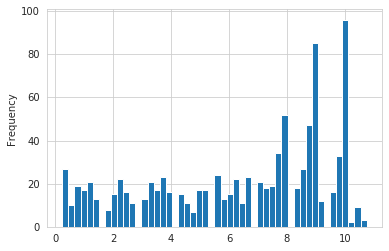

In [13]:
df_data_years.plot(kind='hist', bins=50);

We use this line of code to generate a histogram from a DataFrame called df_data_years. Data in the DataFrame df_data_years is what we want to visualize in the form of a histogram. To create the plot, plot() is called on the df_data_years DataFrame. Our kind parameter is set to 'hist', indicating that we want to create a histogram. The bins parameter is set to 50, indicating that the histogram will have 50 bars or bins to display the data distribution. Finally, In general, this line of code generates a histogram plot to visually represent the data in the df_data_years DataFrame.

We will compare, for example, some of the plots below. the PAST 1-year Dividend Growth to the FUTURE 3-year average Dividend Growth. Based on 600 companies, on average, there are about 3.5 years of such data.


In [14]:
columns = [DIVIDEND_GROWTH_1Y_PAST, DIVIDEND_GROWTH_3Y_FUTURE]
df = df_signals[columns].dropna(how='any')
data_years(df=df).describe()

count    628.000000
mean       3.494825
std        1.817005
min        0.250000
25%        2.000000
50%        3.750000
75%        5.000000
max        6.750000
dtype: float64

A series of steps is performed on the data set stored in the variable "df_signals" in this code. Initially, a new variable named "columns" is created, containing the names of two columns: "DIVIDEND_GROWTH_1Y_PAST" and "DIVIDEND_GROWTH_3Y_FUTURE". A new data frame called "df" is created by selecting only the columns specified in the "columns" variable from the original data frame "df_signals" and removing any rows that contain missing values. In the final step, the function "data_years" is applied to the updated data frame "df" and the "describe" method is used to generate summary statistics, such as count, mean, standard deviation, minimum, and maximum values.

Further below, we will also compare the PAST 3-year average Dividend Growth to the FUTURE 3-year average Dividend Growth. Based on the statistics below, each company had only 2.5 years of data-points:


In [15]:
columns = [DIVIDEND_GROWTH_3Y_PAST, DIVIDEND_GROWTH_3Y_FUTURE]
df = df_signals[columns].dropna(how='any')
data_years(df=df).describe()

count    513.000000
mean       2.526316
std        1.284215
min        0.250000
25%        1.500000
50%        2.750000
75%        3.500000
max        5.000000
dtype: float64

Using this code snippet, two columns, "DIVIDEND_GROWTH_3Y_PAST" and "DIVIDEND_GROWTH_3Y_FUTURE", are defined in a list called "columns." In the next step, it selects these two columns from another DataFrame object called "df_signals" using square bracket notation, and assigns the resulting subset of data to a new DataFrame named "df". Additionally, it drops any rows with missing values in either column. "dropna(how='any')" method.  Finally, it applies the "data_years" function to the "df" DataFrame and calls the "describe()" method. This generates descriptive statistics, such as count, mean, and standard deviation for each column.

This is a fairly short data-period, because the SimFin database currently does not have any more data. Therefore, we should interpret the results with caution, since the data may contain trends specific to that period.


Plotting Functions. Plotting functions are small helper functions.


In [16]:
def plot_scatter(df, x, y, hue=None, num_samples=5000):
    """
    Make a scatter-plot using a random sub-sample of the data.
    
    :param df:
        Pandas DataFrame with columns named `x`, `y` and `hue`.

    :param x:
        String with column-name for the x-axis.

    :param y:
        String with column-name for the y-axis.

    :param hue:
        Either None or string with column-name for the hue.

    :param num_samples:
        Int with number of random samples for the scatter-plot.

    :return:
        matplotlib Axes object
    """

    # Select the relevant columns from the DataFrame.
    if hue is None:
        df = df[[x, y]].dropna()
    else:
        df = df[[x, y, hue]].dropna()

    # Only plot a random sample of the data-points?
    if num_samples is not None and len(df) > num_samples:
        idx = np.random.randint(len(df), size=num_samples)
        df = df.iloc[idx]

    # Ensure the plotting area is a square.
    plt.figure(figsize=(5,5))

    # Make the scatter-plot.
    ax = sns.scatterplot(x=x, y=y, hue=hue, s=20,
                         data=df.reset_index())

    # Move legend for the hue.
    if hue is not None:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    
    return ax

This code defines a function called `plot_scatter` that creates a scatter plot using a random sub-sample of data. The function takes several parameters: `df` is a Pandas DataFrame that should have columns named `x`, `y`, and `hue`; `x` is a string representing the column name for the x-axis; `y` is a string representing the column name for the y-axis; `hue` is an optional string representing the column name for the hue; and `num_samples` is an optional integer representing the number of random samples for the scatter plot.  First, the code selects the relevant columns from the DataFrame based on whether `hue` is None or not. If `hue` is None, it selects only the `x` and `y` columns and removes any rows that have missing values. If `hue` is not None, it selects the `x`, `y`, and `hue` columns and removes any rows with missing values.  Next, the code checks if `num_samples` is not None and if the length of the DataFrame is greater than `num_samples`. If both conditions are true, it generates random indices for the sub-sample using numpy's `randint()` function and selects only those rows from the DataFrame. This ensures that the scatter plot is made using only a random sub-sample of the data.  Then, the code sets the size of the plotting area to a square shape with a width and height of 5 units.  After that, the scatter plot is created using Seaborn's `scatterplot()` function. The `x` and `y` columns are used for the x-axis and y-axis, respectively. The `hue` column is used for the hue if `hue` is not None. The `s` parameter sets the size of the markers on the plot to 20.  Finally, if `hue` is not None, the legend for the hue is moved to the left of the plot using the `legend()` function of the plot object `ax`.  The function then returns the plot object `ax`.

In [17]:
def plot_scatter_fit(df, x, y, num_samples=5000):
    """
    Make a scatter-plot and fit a line through the points.
    
    If there are many data-points, you can use a random
    sample for the scatter-plot, but the linear formula
    is still found using all the data-points.
    
    :param df:
        Pandas DataFrame with columns named `x` and `y`.

    :param x:
        String with column-name for the x-axis.

    :param y:
        String with column-name for the y-axis.

    :param num_samples:
        Int with number of random samples for the scatter-plot.

    :return:
        matplotlib Axes object
    """
    
    # Select the relevant columns from the DataFrame.
    df = df[[x, y]].dropna(how='any').reset_index()

    # Fit a line through all the data-points and get stats.
    slope, intercept, r_value, p_value, std_err = \
        linregress(x=df[x], y=df[y])

    # Show the fitted line and its stats.
    msg = 'y = {0:.2f} * x + {1:.2f} (R^2={2:.2f}, p={3:.0e})'
    msg = msg.format(slope, intercept, r_value**2, p_value)
    print(msg)
    
    # Only plot a random sample of the data-points?
    if num_samples is not None and len(df) > num_samples:
        idx = np.random.randint(len(df), size=num_samples)
        df = df.iloc[idx]

    # Make the scatter-plot with a fitted line.
    # This uses the smaller sample of data-points.
    ax = sns.jointplot(x=x, y=y, kind='reg', data=df,
                       line_kws={'color': 'red'},
                       scatter_kws={'s': 2})

    return ax

This code is a function that takes in a Pandas DataFrame, column names for the x-axis and y-axis, and an optional number of random samples. Using the DataFrame, this function selects only the columns that are relevant and removes any rows with missing values first. With the linregress function, it fits a line through all the data points and calculates the slope, intercept, correlation coefficient (r-value), p-value, and standard error. After that, it prints a message showing Statistical significance of the relationship between x and y is determined by the equation of the fitted line, the R-squared value, and the p-value. The random sample of data points is chosen if the number of random samples is specified and the number of data points exceeds the number specified. Lastly, the function plots a scatterplot with the selected data-points and overlays a fitted line using seaborn's jointplot. Matplotlib returns an Axes object representing the plot in red, with scatter points represented by small circles.

Regression Function. A small helper function for multiple linear regressions.


In [18]:
def regression(df, y, standardize=True, use_constant=True):
    """
    Perform multiple linear-regression on the given DataFrame.
    
    :param df:
        Pandas DataFrame with signals and returns.
        
    :param y:
        String with column-name for the dependent variable.
        This will be taken from the DataFrame `df`.
        
    :param standardize:
        Boolean whether to standardize the predictor variables
        so they have 0 mean and 1 standard deviation.

    :param use_constant:
        Boolean whether to add a 'Constant' column to
        find the bias.
    
    :return:
        StatsModels Regression Results.
    """
    
    # Remove rows with missing values.
    df = df.dropna(how='any').copy()

    # DataFrame for the x-signals.
    df_x = df.drop(columns=[y])
    
    # DataFrame for the y-signal.
    df_y = df[y]

    # Standardize the signals so they have mean 0 and std 1.
    if standardize:
        df_x = (df_x - df_x.mean()) / df_x.std()

    # Add a "constant" column so the regression can find the bias.
    if use_constant:
        df_x['Constant'] = 1.0

    # Perform the regression on this data.
    model = sm.OLS(df_y, df_x).fit()
    
    return model

This code performs multiple linear regression on a given DataFrame. The function takes in the DataFrame, `df`, which contains signals and returns. It also takes a string, `y`, which represents the column name for the dependent variable. The code first removes any rows with missing values from the DataFrame.  Next, the code creates a new DataFrame, `df_x`, by dropping the column specified by `y` from the original DataFrame. This DataFrame will contain the predictor variables for the regression. Another DataFrame, `df_y`, is created which contains only the column specified by `y`. This DataFrame will be used as the response variable.  If the `standardize` parameter is set to `True`, the code standardizes the predictor variables in `df_x` by subtracting the mean and dividing by the standard deviation. This ensures that all predictor variables have a mean of 0 and a standard deviation of 1.  If the `use_constant` parameter is set to `True`, the code adds a column named 'Constant' to `df_x`, which is set to a constant value of 1. This allows the regression to find the bias.  Finally, the code performs the linear regression using the `df_y` variable as the response variable and the `df_x` variable as the predictor variables. The result of the regression is stored in the `model` variable, which is returned as the output of the function.

Past vs.
Future Dividends.

Let us first compare the PAST and FUTURE Dividends.
The first scatter-plot shows the raw cash amounts in USD.
This fits a straight line with $R^2$ nearly 1, so it is a really good fit.
But it has a tremendous range of values between zero and 14b USD, and the majority of points are concentrated in a small value-range.


y = 1.05 * x + 13152720.73 (R^2=0.98, p=0e+00)


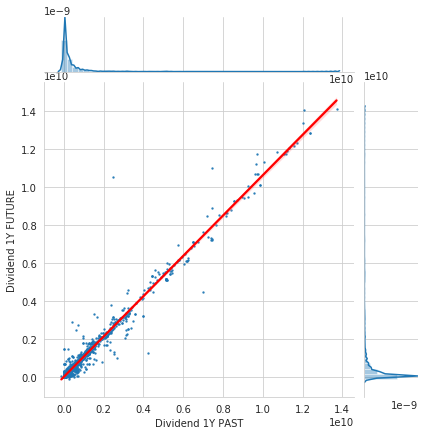

In [19]:
plot_scatter_fit(df=df_signals,
                 x=DIVIDEND_1Y_PAST,
                 y=DIVIDEND_1Y_FUTURE);

The code is calling a function named `plot_scatter_fit` with three arguments: `df`, `x`, and `y`. The `df` argument is being passed a DataFrame object called `df_signals`. The `x` argument is being passed a variable named `DIVIDEND_1Y_PAST`, and the `y` argument is being passed a variable named `DIVIDEND_1Y_FUTURE`.  The purpose of the `plot_scatter_fit` function is to generate a scatter plot, or a graph that displays the relationship between two variables, in this case, `DIVIDEND_1Y_PAST` and `DIVIDEND_1Y_FUTURE`. The function takes the DataFrame `df_signals` as input and uses the variables `DIVIDEND_1Y_PAST` as the x-axis and `DIVIDEND_1Y_FUTURE` as the y-axis.  The function likely has additional code inside it that handles the plotting of the scatter plot. It may also include code to fit a line or curve to the data points on the scatter plot to visualize any potential trend or relationship between the two variables. Without the code for the `plot_scatter_fit` function, it is not It is possible to provide a more detailed explanation of its specific functions.

Let us instead try and plot the Log10 dividend amounts.
This effectively shows the "number of zeros" so that 1 million becomes the value 6 because it has 6 zeros, and 1 billion becomes the value 9 because it has 9 zeros, etc.

This creates a more narrow range of values for the dividend amounts.
But the line-fit is still nearly diagonal with $R^2$ near 1.
This shows that the dividend amount tends to be almost the same from one year to the next, with only minor variation.


y = 0.98 * x + 0.21 (R^2=0.94, p=0e+00)


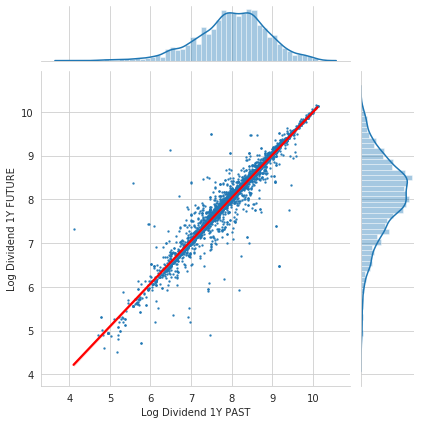

In [20]:
plot_scatter_fit(df=df_signals,
                 x=LOG_DIVIDEND_1Y_PAST,
                 y=LOG_DIVIDEND_1Y_FUTURE);

To analyze the relationship between two variables in a given dataset, this code plots a scatter plot alongside a linear regression fit line. A dataset, called 'df_signals', is passed as an input to the function, which specifies which variables will be plotted on the x-axis and which variables will be plotted on the y-axis. The variable 'LOG_DIVIDEND_1Y_PAST' is passed as the x-axis variable, and 'LOG_DIVIDEND_1Y_FUTURE' is passed as the y-axis variable. 'LOG_DIVIDEND_1Y_PAST' is plotted on the x-axis and 'LOG_DIVIDEND_1Y_FUTURE' on the y-axis to create a plot. Data points are displayed as dots on the plot, and a linear regression fit line is added to the plot. This line represents the best straight-line fit through the data points, which helps visualize any linear relationship or trend between the two variables. It is determined by using a mathematical algorithm that minimizes the The distance between the line and the data points. Seeing the scatter plot and the fit line helps one understand the relationship between the two variables and observe any patterns or trends. Based on the data, this can be useful to identify correlations or make predictions.

In order to better understand whether some of the signals can be used to predict FUTURE Dividend Growth, let us consider some basic statistics first. On average, dividends have grown by 10.2% a year over the past few years. The Cash Dividends Paid from the Cash-Flow Statement are NOT per-share numbers.


In [21]:
df_signals[DIVIDEND_GROWTH_1Y_FUTURE].describe()

count    17740.000000
mean         0.102350
std          0.148164
min         -0.327041
25%          0.015462
50%          0.074145
75%          0.152069
max          0.759348
Name: Dividend Growth 1Y FUTURE, dtype: float64

The code provided is used to generate a summary description of a specific column called "DIVIDEND_GROWTH_1Y_FUTURE" in a DataFrame called "df_signals". It is possible to compute various statistical measures based on this column using the "describe()" function, including count, mean, standard deviation, minimum value, 25th percentile, median (50th percentile), 75th percentile, and maximum value. The code calculates and presents statistical information about the values in the "DIVIDEND_GROWTH_1Y_FUTURE" column. This includes information like how many values are present, the average value, how spread out the values from the average, the smallest and largest values, and values that represent different points on the distribution of the data. This code will provide a brief statistical summary of the column's data as an output.

A histogram can also be used to show 1-year Dividend Growth:


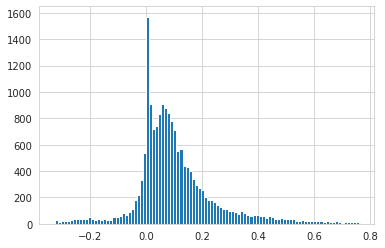

In [22]:
df_signals[DIVIDEND_GROWTH_1Y_FUTURE].hist(bins=100);

The purpose of a histogram plot is to visualize the distribution of values within a dataset. This code performs a histogram plot on a column of data called "df_signals[DIVIDEND_GROWTH_1Y_FUTURE]". The code divides the range of values into 100 equal intervals and counts how many times the value falls into each interval by specifying "bins=100". A histogram plot displays the distribution's shape, with its x axis representing the intervals or ranges of values and its y-axis representing the values. This code visualizes the distribution of the data in "df_signals[DIVIDEND_GROWTH_1Y_FUTURE]" by using a histogram plot of 100 bins.

We can also show the basic statistics for 3-year average Dividend Growth. Based on annualized data, the dividend grew by 10.3% on average over three years.


In [23]:
df_signals[DIVIDEND_GROWTH_3Y_FUTURE].describe()

count    11851.000000
mean         0.102646
std          0.111082
min         -0.242532
25%          0.031781
50%          0.086955
75%          0.159636
max          0.460588
Name: Dividend Growth 3Y Avg. FUTURE, dtype: float64

This code is used to describe a specific column in a DataFrame called `df_signals`. The column that is being described is named `DIVIDEND_GROWTH_3Y_FUTURE`.   To describe this column, the code performs several steps. Firstly, it retrieves the column from the DataFrame. Then, it calculates various statistical measures on the values in the column, such as the number of values, the mean, standard deviation, minimum and maximum values, as well as quartiles.   By using the `describe()` function, the code essentially summarizes the key characteristics of the `DIVIDEND_GROWTH_3Y_FUTURE` column in the `df_signals` DataFrame. This provides a high-level overview of the distribution and central tendency of the values in the column, giving insights into its properties and potential patterns.

In a histogram, we can again see the distribution:


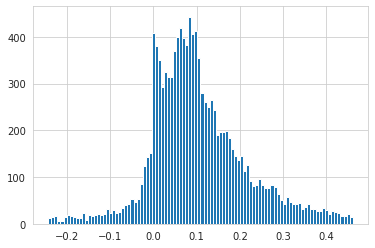

In [24]:
df_signals[DIVIDEND_GROWTH_3Y_FUTURE].hist(bins=100);

Using a pandas DataFrame object, specifically df_signals, this code line plots a histogram for the column DIVIDEND_GROWTH_3Y_FUTURE. In other words, the code visualizes the distribution of values within the DIVIDEND_GROWTH_3Y_FUTURE column of the df_signals DataFrame. An overview of the overall distribution pattern will be provided by a histogram, which will display how frequently different values occur within the column.


Signal Correlation. Let us now investigate if any of the signals can be used to predict the FUTURE Dividend Growth for a company. We begin by calculating the linear correlations between the various signals and dividend growth.


In [25]:
%%time
df_corr = df_signals.corr()

# New column names.
SIGNALS_1Y = '1-Year Dividend Growth'
SIGNALS_3Y = '3-Year Avg. Dividend Growth'

# Create a new DataFrame with the correlations.
data = \
{
    SIGNALS_1Y: df_corr[DIVIDEND_GROWTH_1Y_FUTURE],
    SIGNALS_3Y: df_corr[DIVIDEND_GROWTH_3Y_FUTURE]
}
df = pd.DataFrame(data=data)

CPU times: user 428 ms, sys: 0 ns, total: 428 ms
Wall time: 430 ms


A DataFrame called "df_signals" is used to calculate the correlation between different signals. A correlation matrix is first calculated using the function "corr()" and then stored in a DataFrame called "df_corr". A new column called "1-Year Dividend Growth" and "3-Year Avg. Dividend Growth" is then created by extracting specific columns from SIGNALS_1Y and SIGNALS_3Y. The code then creates a new DataFrame called "df" by using the variables. The correlation matrix is mapped to the column names with a dictionary called "data." As shown in the code snippet, the columns to be extracted are specified using variables called DIVIDEND_GROWTH_1Y_FUTURE and DIVIDEND_GROWTH_3Y_FUTURE.   Finally, the code uses the dictionary "data" to create a new DataFrame "df" by passing it to the pandas "DataFrame()" function. The resulting DataFrame "df" will have two There are two columns named "1-Year Dividend Growth" and "3-Year Avg. Dividend Growth", and the values in these columns represent the correlation between the respective signals and future dividend growth.

As a result, we can demonstrate the correlation between the various signals and the dividend growth rates for the next 1 and 3 years, respectively. A correlation coefficient of 1 means the correlation is perfect so the two variables always move together, while a correlation of 0 means there is no linear relation between the two variables, and a correlation of -1 means the two variables always move perfectly opposite to each other. Due to the fact that we are Here, we are only concerned with the strength of the correlation, not its direction.

In [26]:
df.abs().sort_values(by=SIGNALS_3Y, ascending=False)

1-Year Dividend Growth  \
Dividend Growth 3Y Avg. FUTURE                               0.755808   
Dividend Growth 1Y FUTURE                                    1.000000   
Dividend Growth 1Y PAST                                      0.304895   
Dividend Growth 3Y Avg. PAST                                 0.289479   
Log Revenue (1Y Change)                                      0.180468   
Sales Growth                                                 0.175427   
Sales Growth YOY                                             0.167108   
Dividends / FCF                                              0.115312   
Assets Growth YOY                                            0.160180   
Assets Growth                                                0.170497   
Interest Coverage (1Y Change)                                0.096722   
R&D / Revenue (1Y Change)                                    0.088416   
R&D / Gross Profit (1Y Change)                               0.083353   
Return on Research Capital (1Y Change)                       0.082262   
(Dividends + Share Buyback) / FCF                            0.070832   
Assets Growth QOQ                                            0.098024   
Dividend 1Y PAST                                             0.056062   
Debt Ratio (1Y Change)                                       0.063503   
Earnings Growth                                              0.095954   
Earnings Growth YOY                                          0.080676   
Return on Equity                                             0.080715   
Interest Coverage                                            0.055912   
Net Profit Margin                                            0.104547   
Inventory Turnover (1Y Change)                               0.031864   
Asset Turnover (1Y Change)                                   0.001249   
Return on Assets                                             0.090772   
CapEx / (Depr + Amor) (1Y Change)                            0.040383   
FCF Growth                                                   0.058953   
Dividend 1Y FUTURE                                           0.023919   
Gross Profit Margin                                          0.055287   
Sales Growth QOQ                                             0.049625   
Return on Assets (1Y Change)                                 0.057133   
Gross Profit Margin (1Y Change)                              0.055941   
Net Profit Margin (1Y Change)                                0.059405   
Return on Equity (1Y Change)                                 0.042354   
FCF Growth YOY                                               0.025955   
Log Dividend 1Y FUTURE                                       0.065891   
CapEx / (Depr + Amor)                                        0.052993   
Quick Ratio (1Y Change)                                      0.027730   
Earnings Growth QOQ                                          0.035131   
Log Dividend 1Y PAST                                         0.000044   
Share Buyback / FCF                                          0.026806   
R&D / Gross Profit                                           0.004034   
Share Buyback / FCF (1Y Change)                              0.005144   
Asset Turnover                                               0.028100   
Inventory Turnover                                           0.024872   
Dividends / FCF (1Y Change)                                  0.023347   
Net Acquisitions / Total Assets (1Y Change)                  0.018729   
Current Ratio (1Y Change)                                    0.016695   
Debt Ratio                                                   0.020970   
Return on Research Capital                                   0.014223   
Net Acquisitions / Total Assets                              0.013261   
(Dividends + Share Buyback) / FCF (1Y Change)                0.004929   
Quick Ratio                                                  0.022446   
Current Ratio                   

This code performs a series of steps on a DataFrame object, which is typically used to store and manipulate data in tabular form.   First, the `.abs()` function is applied to the DataFrame, which returns a new DataFrame with all the values converted to their absolute values. This means that all negative values in the DataFrame become positive.  Next, the `.sort_values()` function is used to sort the DataFrame based on a specific column called `SIGNALS_3Y`. The `by` parameter is set to `SIGNALS_3Y`, which means the sorting will be based on the values in the `SIGNALS_3Y` column. The `ascending` parameter is set to `False`, which means the sorting will be in descending order.  Overall, this code takes a DataFrame, converts all the values to their absolute values, and then sorts the DataFrame based on the values in the `SIGNALS_3Y` column, in descending order.

For some of the signals with the highest correlation, we will fit a Linear Regression Model. Due to the fact that many of the signals contain NaN (Not-a-Number), we do not fit the regression model to all the signals, which results in the entire rows being removed with NaN removed. In addition, the correlation numbers already show that many of the signals are not linearly related to the FUTURE Dividend Growth anyway. As a result, the regression model has a coefficient of 0.13$, which is pretty weak. Before fitting the regression model, the data are standardized to have a zero mean and 1 standard deviation. The coefficients indicate which signals are most important in predicting the FUTURE 1-year Dividend Growth, which is by far the PAST 3-year average Dividend Growth, followed by the PAST 1-year Dividend Growth.

In [27]:
# Only use some of the signals in the regression.
columns = [DIVIDEND_GROWTH_1Y_FUTURE, DIVIDEND_GROWTH_1Y_PAST,
           DIVIDEND_GROWTH_3Y_PAST, SALES_GROWTH,
           PAYOUT_RATIO, ASSETS_GROWTH_YOY]

# Fit the regression model.
model = regression(df=df_signals[columns],
                   y=DIVIDEND_GROWTH_1Y_FUTURE, standardize=True)

# Show the results.
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Dividend Growth 1Y FUTURE   R-squared:                       0.134
Model:                                   OLS   Adj. R-squared:                  0.133
Method:                        Least Squares   F-statistic:                     211.2
Date:                       Wed, 15 Apr 2020   Prob (F-statistic):          3.83e-210
Time:                               14:56:03   Log-Likelihood:                 5711.5
No. Observations:                       6859   AIC:                        -1.141e+04
Df Residuals:                           6853   BIC:                        -1.137e+04
Df Model:                                  5                                         
Covariance Type:                   nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Dividend Growth 1Y PAST          0.0130      0.002      6.660      0.000       0.009       0.017
Dividend Growth 3Y Avg. PAST     0.0232      0.002     11.926      0.000       0.019       0.027
Sales Growth                     0.0074      0.001      5.269      0.000       0.005       0.010
Dividends / FCF                 -0.0099      0.001     -7.690      0.000      -0.012      -0.007
Assets Growth YOY                0.0104      0.001      7.495      0.000       0.008       0.013
Constant                         0.0884      0.001     69.563      0.000       0.086       0.091
==============================================================================
Omnibus:                     2558.033   Durbin-Watson:                   0.787
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21391.372
Skew:                           1.555   Prob(JB):                         0.00
Kurtosis:                      11.073   Cond. No.                         2.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This code is performing a regression analysis on a dataset. In the first step, a list of selected columns (or signals) is defined, which includes variables related to dividend growth, sales growth, payout ratio, and assets growth.   The regression model is then fitted using the `regression` function. The `df` parameter represents the dataset, which appears to be stored in a variable called `df_signals`. The `y` parameter specifies the target variable for the regression, which is the variable `DIVIDEND_GROWTH_1Y_FUTURE`. The `standardize` parameter is set to `True`, which suggests that the variables are being standardized or normalized before fitting the model.  Finally, the results of the regression analysis are displayed using the `summary` method of the model object. This summary provides information such as the coefficient values, p-values, and other statistics that help interpret the relationships between the variables in the regression model.

Let us compare past and future dividend growth in order to find out if PAST Dividend Growth can be used for predicting FUTURE Dividend Growth. This scatter plot shows a positive correlation between the past and future one-year dividend growth. There are 5000 data points in the plot that are randomly selected from a total of 13,000. However, the linear formula printed above the plot is fitting the whole dataset. A scatter plot shows one data point, which is the 1-year PAST Dividend Growth for a single company and one of its financial reports, and the 1-year Dividend Growth starting in the same quarter and going into the future.

y = 0.28 * x + 0.06 (R^2=0.09, p=8e-298)


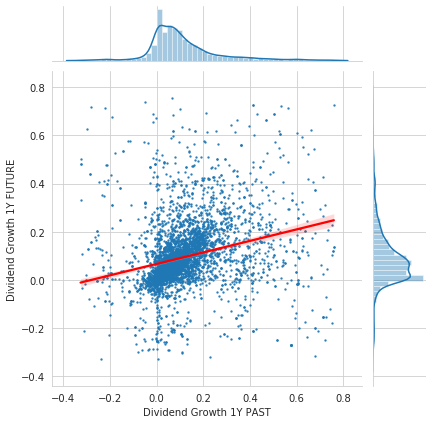

In [28]:
plot_scatter_fit(df=df_signals,
                 x=DIVIDEND_GROWTH_1Y_PAST,
                 y=DIVIDEND_GROWTH_1Y_FUTURE);

The following code creates a scatter plot with a fitted line using a DataFrame called df_signals. In this plot, the x-axis contains DIVIDEND_GROWTH_1Y_PAST and the y-axis contains DIVIDEND_GROWTH_1Y_FUTURE. As an argument, the code passes the DataFrame df_signals to a function called plot_scatter_fit. The function specifies that the x-axis values should be taken from the column DIVIDEND_GROWTH_1Y_PAST of the DataFrame, while the y-axis values will come from the column DIVIDEND_GROWTH_PAST of the DataFrame. This function generates a scatter plot using these x and y values from the column DIVIDEND_GROWTH_1Y_FUTURE. Additionally, it uses some kind of regression technique to fit a line to the scatter plot data. Based on the fitted line, it can be used to predict the future value of y given a different x value by relating the x and y values mathematically. In general, this code assists in visualizing the relationship between DIVIDEND_GROWTH_1Y_PAST and DIVIDEND_GROWTH_1Y_FUTURE in A scatter plot with a fitted line is generated from DataFrame df_signals.

Let us now compare the PAST 3-year average Dividend Growth to the FUTURE 3-year average Dividend Growth. The plot looks quite similar to the one above for 1-year Dividend Growth. Again, there is a positive correlation.


y = 0.27 * x + 0.06 (R^2=0.07, p=6e-80)


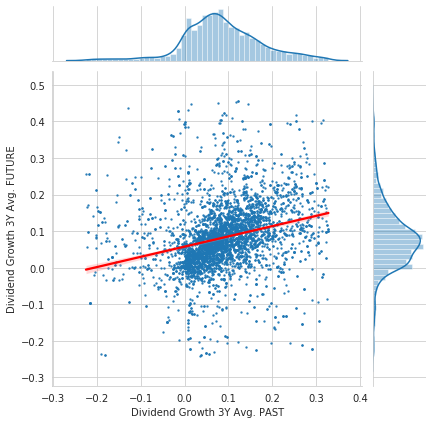

In [29]:
plot_scatter_fit(df=df_signals,
                 x=DIVIDEND_GROWTH_3Y_PAST,
                 y=DIVIDEND_GROWTH_3Y_FUTURE);

Using this code, a scatter plot will be generated based on a dataframe called "df_signals" with a regression line. In the plot, the x-axis represents the attribute "DIVIDEND_GROWTH_3Y_PAST", while the y-axis represents the attribute "DIVIDEND_GROWTH_3Y_FUTURE". The scatter plot will consist of points that correspond to the values of these two attributes for each entry in the dataframe. The x-axis will show the values of A value of "DIVIDEND_GROWTH_3Y_PAST" will be shown on the y-axis, while a value of "DIVIDEND_GROWTH_3Y_FUTURE" will be shown on the y-axis. On the scatter plot, the code will also generate a regression line that represents the relationship between the two attributes by fitting the data points best. The relationship between future dividend growth and past dividend growth for the given dataset can be revealed using this line.

Assets Growth YOY. Let us now consider if the Year-Over-Year (YOY) Assets Growth can predict the FUTURE 1-year Dividend Growth. Unfortunately, it does not work very well.


y = 0.19 * x + 0.09 (R^2=0.03, p=4e-90)


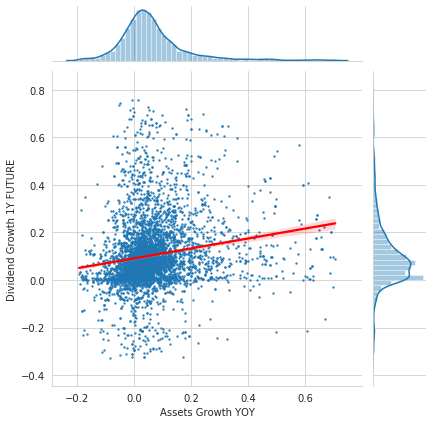

In [30]:
plot_scatter_fit(df=df_signals,
                 x=ASSETS_GROWTH_YOY,
                 y=DIVIDEND_GROWTH_1Y_FUTURE);

This code uses to plot a scatter plot and fit a line of best fit to the data. Input data is stored in a DataFrame titled 'df_signals'. An asset growth rate of over a year is represented by the variable 'ASSETS_GROWTH_YOY' on the x-axis of the scatter plot. On the y-axis, the variable 'DIVIDEND_GROWTH_1Y_FUTURE' represents the estimated dividend growth rate one year from now. This code generates a scatter plot based on this measure. Data points represent specific combinations of asset growth and dividend growth for these two variables. As part of the code, a line of best fit is also fitted to the data points to determine the overall relationship between dividend growth and asset growth. In order to determine whether the two variables have a positive, negative, or no correlation, this line can be used.

We can also try and see if the YOY Assets Growth can predict the FUTURE 3-year average Dividend Growth. There is a positive correlation, but the R2 is very low.


y = 0.15 * x + 0.09 (R^2=0.03, p=4e-62)


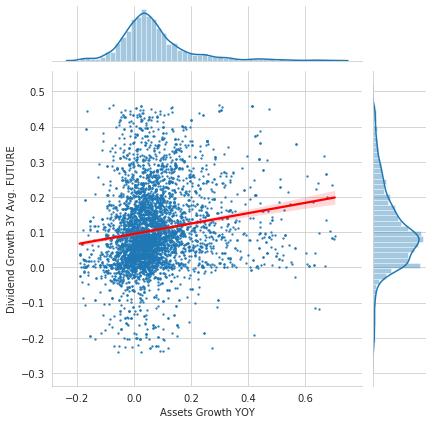

In [31]:
plot_scatter_fit(df=df_signals,
                 x=ASSETS_GROWTH_YOY,
                 y=DIVIDEND_GROWTH_3Y_FUTURE);

This code is used to plot a scatter plot of two variables from a dataframe called 'df_signals'. The x-axis of the scatter plot represents the variable 'ASSETS_GROWTH_YOY', and the y-axis represents the variable 'DIVIDEND_GROWTH_3Y_FUTURE'.   The code takes three arguments: 'df_signals' which is the data frame containing the data, 'ASSETS_GROWTH_YOY' is the variable to be plotted on the x-axis, and 'DIVIDEND_GROWTH_3Y_FUTURE' is the variable to be plotted on the x-axis. Scatter plots show the relationship between two variables in a dataset. They are useful for identifying patterns or trends, as well as outliers or observations that deviate significantly from the overall pattern.

However, if we zoom in on the part of the plot where the YOY Assets Growth is greater than 0.2 (or 20%), we see that most FUTURE 1-year average Dividend Growths are greater than zero. Knowing this might be helpful.


y = -0.04 * x + 0.15 (R^2=0.00, p=3e-01)


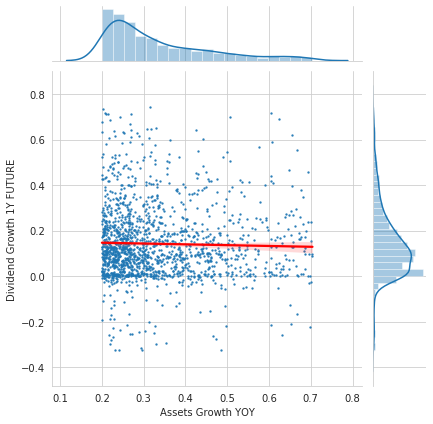

In [32]:
# Only use some of the data-points.
mask = (df_signals[ASSETS_GROWTH_YOY] > 0.2)
df = df_signals.loc[mask]

plot_scatter_fit(df=df,
                 x=ASSETS_GROWTH_YOY,
                 y=DIVIDEND_GROWTH_1Y_FUTURE);

It creates a mask to determine if the values in the column 'ASSETS_GROWTH_YOY' of the DataFrame 'df_signals' are greater than 0. This mask filters out only the data points that meet that condition. By applying the mask to the DataFrame 'df_signals', it creates a new DataFrame called 'df'. The 'loc' method selects rows based on the provided boolean mask.   The function 'plot_scatter_fit' is called with the In the scatter plot, 'x' is set to 'ASSETS_GROWTH_YOY', which indicates that the column with that name will be displayed on the x-axis. - 'df' represents the newly created DataFrame 'df', which contains only the selected data points. As a result, a column with the name 'DIVIDEND_GROWTH_1Y_FUTURE' will be shown on the scatter plot's y-axis. This code filters out data points that have a value of With 'ASSETS_GROWTH_YOY' greater than 0.2, a scatter plot using the filtered data is plotted, with 'ASSETS_GROWTH_YOY' as the x-axis and 'DIVIDEND_GROWTH_1Y_FUTURE' as the y-axis.

Comparing the YOY Assets Growth greater than 0.2 to the FUTURE 3-year average Dividend Growth, we get a very similar plot.


y = -0.03 * x + 0.14 (R^2=0.00, p=4e-01)


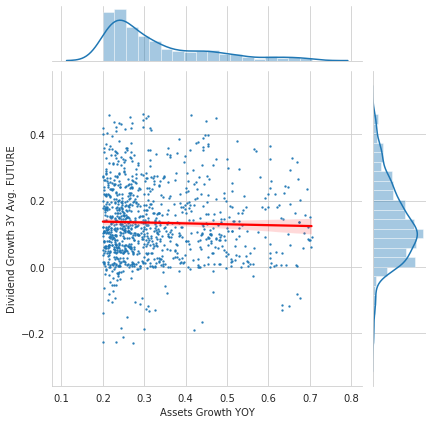

In [33]:
plot_scatter_fit(df=df,
                 x=ASSETS_GROWTH_YOY,
                 y=DIVIDEND_GROWTH_3Y_FUTURE);

This code calls the plot_scatter_fit function and passes three arguments to it. The first argument, "df", indicates a DataFrame object containing data. The second argument, "x", is the variable name that represents the column in the DataFrame to be used as the x-axis values for the scatter plot. The third argument, "y", is the variable name that represents the column in the DataFrame to be used as the y-axis values for the scatter plot. The DataFrame will be used to generate a scatter plot with a curve fit line. In the scatter plot, the x-axis represents the values from the "ASSETS_GROWTH_YOY" column of the DataFrame, while the y-axis represents the values from the "DIVIDEND_GROWTH_3Y_FUTURE" column. In addition to the scatter plot, a curve fit line will appear on the x and y variables in an effort to visualize an overall trend or relationship between them. This can help in analyzing any potential correlation between them. Analyzing two variables and identifying any patterns or trends.

Sales Growth. Let us now consider if the TTM Sales Growth can predict the FUTURE 1-year Dividend Growth. The fitted line has only $R^2 = 0.03$.


y = 0.24 * x + 0.09 (R^2=0.03, p=2e-102)


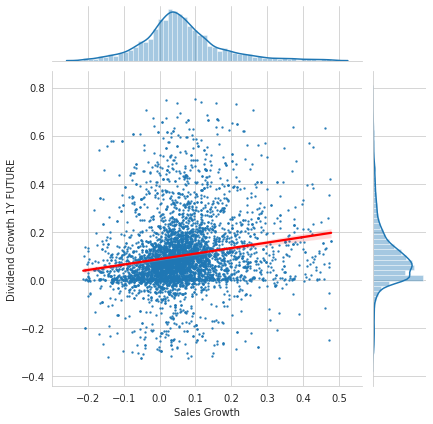

In [34]:
plot_scatter_fit(df=df_signals,
                 x=SALES_GROWTH,
                 y=DIVIDEND_GROWTH_1Y_FUTURE);

A function called "plot_scatter_fit" is called in the code and three arguments are provided: a dataframe named "df_signals", a variable named "SALES_GROWTH" as the x-axis, and a variable named "DIVIDEND_GROWTH_1Y_FUTURE" as the y-axis. In this code, we plot a scatter plot whose x-axis represents the values of "SALES_GROWTH" and the y-axis represents "DIVIDEND_GROWTH_1Y_FUTURE". The scatter plot is a type of data visualization. In this example, it shows the relationship between sales growth and dividend growth. There may be additional functionality included in the plot_scatter_fit function, such as fitting a regression line to the scatter plot or adding annotations and labels. It is not possible to provide a detailed explanation of all the steps involved in the code without further information on the plot_scatter_fit function.

We can also try and see if the TTM Sales Growth can predict the FUTURE 3-year average Dividend Growth. This time the correlation is positive, but the correlation is low.


y = 0.21 * x + 0.09 (R^2=0.05, p=9e-98)


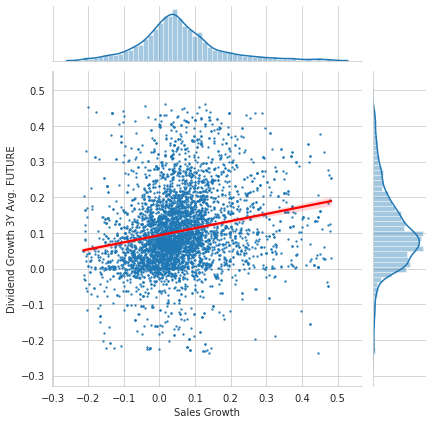

In [35]:
plot_scatter_fit(df=df_signals,
                 x=SALES_GROWTH,
                 y=DIVIDEND_GROWTH_3Y_FUTURE);

Using the "plot_scatter_fit" function, this code creates a scatter plot from a DataFrame that is presumably containing information on sales growth and future dividend growth for certain companies. In this function, two variables will be plotted against each other, with sales growth on the x-axis and dividend growth on the y-axis. When the code specifies "x=SALES_GROWTH" and "y=DIVIDEND_GROWTH_3Y_FUTURE", it indicates that "SALES_GROWTH" column in the DataFrame should be used as the x-variable, and "DIVIDEND_GROWTH_3Y_FUTURE" column should be used as the y-variable for the scatter plot. Using data from the specified DataFrame, this code plots sales growth against dividend growth.

However, if we zoom in on the part of the plot where the TTM Sales Growth is greater than 0.1 (or 10%), we see that most FUTURE 1-year Dividend Growths are significantly greater than zero. It could be useful to know this.


y = 0.04 * x + 0.13 (R^2=0.00, p=2e-01)


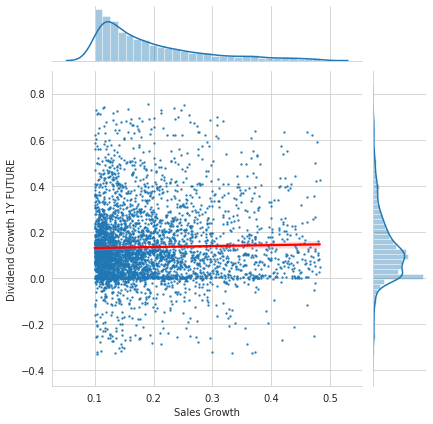

In [36]:
# Only use data-points with positive Sales Growth.
mask = (df_signals[SALES_GROWTH] > 0.1)
df = df_signals.loc[mask]

plot_scatter_fit(df=df,
                 x=SALES_GROWTH,
                 y=DIVIDEND_GROWTH_1Y_FUTURE);

This code is designed to perform several steps.   First, it creates a mask using a condition from a data frame called `df_signals`. The condition is that the value in the column `SALES_GROWTH` should be greater than 0.The mask will be used to filter out data points that do not meet this condition.   Next, it applies this mask to the `df_signals` data frame and saves the filtered data in a new data frame called `df`.   Finally, it calls a function called `plot_scatter_fit` and passes the filtered This function is likely used to plot a scatter plot and fit a line to the data points to visualize the relationship between sales growth and future dividend growth.

A similar plot appears when we compare TTM Sales Growth with FUTURE 3-year average Dividend Growth.


y = 0.01 * x + 0.13 (R^2=0.00, p=8e-01)


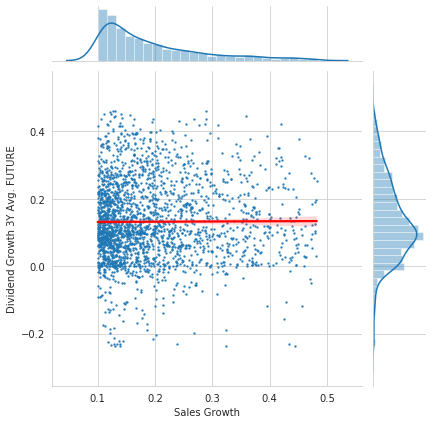

In [37]:
plot_scatter_fit(df=df,
                 x=SALES_GROWTH,
                 y=DIVIDEND_GROWTH_3Y_FUTURE);

It takes a DataFrame named 'df' as input, along with two columns named 'SALES_GROWTH' and 'DIVIDEND_GROWTH_3Y_FUTURE'. It then plots a scatter plot with 'SALES_GROWTH' values on the x-axis and 'DIVIDEND_GROWTH_3Y_FUTURE' values on the y-axis. This scatter plot illustrates how these two variables are related. Each data point represents the value 'SALES_GROWTH' and 'DIVIDEND_GROWTH_3Y_FUTURE' for each record in the DataFrame.  By plotting the data We can see if there is any correlation or pattern between future dividend growth and sales growth by observing the points. As a result, we can identify any potential relationships between these two variables. We can also identify outliers and clusters of data points using the scatter plot. By providing a visual representation of the data, this code provides insights into the relationship between future dividend growth and sales growth.

The Dividend Payout Ratio is a metric used to understand what proportion of a company's earnings are distributed as dividends to its shareholders. We calculate this ratio differently from other methods, since we use Free Cash Flow instead of Net Income. The Payout Ratio formula is: "Dividends Paid over the trailing twelve months (TTM), divided by Free Cash Flow over the trailing twelve months."  This formula is Divided by Net Cash from Operations over the trailing twelve months and Capital Expenditures over the trailing twelve months, the Payout Ratio can be further broken down as follows: "Dividends Paid over the trailing twelve months divided by Net Cash from Operations over the trailing twelve months." In order to visualize this relationship, we have created a scatter plot showing that higher dividend payout ratios may result in lower dividend growth over the next three years. The R-squared value, which indicates how closely the data fit the regression line, As a result, the data points are quite scattered, suggesting a very weak relationship.

y = -0.09 * x + 0.14 (R^2=0.03, p=1e-67)


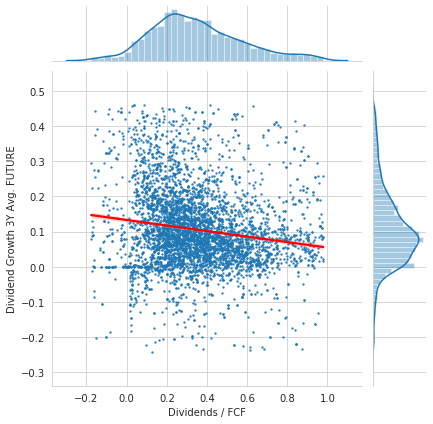

In [38]:
plot_scatter_fit(df=df_signals,
                 x=PAYOUT_RATIO,
                 y=DIVIDEND_GROWTH_3Y_FUTURE);

This code is used to create a scatter plot with a linear regression line for a dataset called df_signals. In the scatter plot, the x-axis will represent the PAYOUT_RATIO values from the dataset, and the y-axis will represent the DIVIDEND_GROWTH_3Y_FUTURE values. It is possible to visualise the relationship between dividend payout ratios and dividend growth by plotting these two variables together.   The linear regression line that will be included in the scatter plot will show the overall This will help us understand if there is a positive or negative correlation between the payout ratio and dividend growth in the future.

As a fundamental component of long-term stock forecasting, forecasting dividends is essential. We tested which signals would be able to predict future dividends, along with dividend growth rates of the future one and three years. In this study, we found that the PAST 1 year dividend was a very strong predictor of the FUTURE 1 year dividend with a value close to 1. Note that these are the total Cash Dividends Paid, which are derived from the Cash-Flow. It is NOT the per-share dividends that will be affected by changes in share counts, e.g. from share buybacks, which may be studied in a future paper.  - The Dividend Growth is much harder to predict from the signals we considered here.  - The strongest predictor for the FUTURE 1-year Dividend Growth was the PAST 1-year Dividend Growth, but the data-points were so dispersed that $R^2 = 0.09$. Similarly, the strongest predictors for the FUTURE 3-year average Dividend Growth was the PAST 1-year Dividend Growth, but again with similar low $R^2$.  - The Year-Over-Year (YOY) Assets Growth Also, YOY Assets Growth greater than 20% was a weak predictor of the FUTURE Dividend Growth. However, FUTURE 1-year and 3-year Dividend Growth was nearly always positive when only considering this. Also, Trailing Twelve Months (TTM) Sales Growth was a weak predictor of FUTURE Dividend Growth. However, we found that FUTURE Dividend Growth was nearly always positive if TTM Sales Growth was greater than 10%.  Also note that we used The data was only available until April 2020 for individual stocks and only went back about 6 years on average, with a maximum period of 11 years for one stock. It would be ideal to conduct this type of study with 20-30 years of dividend growth data, in which case stronger predictors might be identified over a five to ten year period.